In [1]:
import itertools

import contextily as ctx
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from geopy.distance import geodesic
from pyproj import Transformer
from shapely.geometry import LineString, Point
from shapely.ops import linemerge

import math

from utils import compute_length

from railroad import load_graph, save_graph
from utils import print_graph_info

np.random.seed(42)


ctx.set_cache_dir("~/.contextily_cache")

In [2]:

def find_nodes_within_radius(graph, center_x, center_y, radius):
    """
    Find all nodes within a given radius from a specified point using geodesic distance.

    Parameters:
    - graph: networkx.Graph, the graph data structure.
    - center_x, center_y: float, the coordinates of the center point.
    - radius: float, the radius within which to search for nodes (in kilometers).

    Returns:
    - list: Node IDs that are within the specified radius.
    """
    center_point = (center_y, center_x)  # Geopy expects (latitude, longitude)
    return [
        node for node, data in graph.nodes(data=True)
        if geodesic(center_point, (data['coord'].y, data['coord'].x)).kilometers <= radius
    ]

In [3]:
def haversine_distance(coord1, coord2):
    """
    Calculate the great-circle distance between two points on the Earth (specified in decimal degrees).
    This is more accurate for geographical coordinates than straight-line distances.
    """
    lon1, lat1 = coord1
    lon2, lat2 = coord2

    # Convert latitude and longitude from degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * \
        math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r


def get_nodes_sorted_by_distance(G, coordinate):
    """
    Get nodes sorted by their distance from the given coordinate.

    Parameters:
    G : nx.Graph
        The input graph with nodes containing 'geometry' as LineString.
    coordinate : tuple
        The coordinate (longitude, latitude) to calculate distances from.

    Returns:
    list of tuples
        List of tuples (node, distance) sorted by distance.
    """
    distances = []

    for node, data in G.nodes(data=True):
        geometry = data.get('geometry')
        if geometry and geometry.is_empty is False:
            # Calculate the midpoint of the LineString
            centroid = geometry.centroid
            dist = haversine_distance(coordinate, (centroid.x, centroid.y))
            distances.append((node, dist))

    # Sort the nodes by distance
    distances.sort(key=lambda x: x[1])

    return distances

In [4]:
def find_all_edges_for_nodes(graph, nodes):
    """
    Retrieve all incoming and outgoing edges for the specified nodes.

    Parameters:
    - graph: networkx.Graph, the graph data structure.
    - nodes: tuple(s), the nodes for which to find edges.

    Returns:
    - dict: A dictionary where each key is a node and the value is a list of tuples
            containing the edge (start_node, end_node) and the associated edge data.
    """
    node_edges = {}

    for node in nodes:
        edges = []

        # Get all outgoing edges
        for neighbor in graph.neighbors(node):
            edge_data = graph.get_edge_data(node, neighbor)
            if edge_data:
                edges.append(((node, neighbor), edge_data))

        # Get all incoming edges
        if graph.is_directed():
            for neighbor in graph.predecessors(node):
                edge_data = graph.get_edge_data(neighbor, node)
                if edge_data:
                    edges.append(((neighbor, node), edge_data))

        node_edges[node] = edges

    return node_edges

In [5]:
def remove_nodes(G: nx.Graph, nodes: list):
    for node in nodes:
        assert len(node) == 2, f"Invalid node: {node}"
        G.remove_node(node)
        G.remove((node[1], node[0]))

In [6]:
def find_nodes_in_bounds_edge_graph(edge_graph, x_min, x_max, y_min, y_max):
    """
    Find all nodes in the edge-based graph whose geometries fall within the specified coordinate bounds.

    Parameters:
    - edge_graph: networkx.Graph, the edge-based graph data structure.
    - x_min, x_max: float, the bounds for the x-coordinates.
    - y_min, y_max: float, the bounds for the y-coordinates.

    Returns:
    - list: Node IDs that are within the specified bounds.
    """
    return [
        node for node, data in edge_graph.nodes(data=True)
        if any(
            x_min <= x <= x_max and y_min <= y <= y_max
            for x, y in data['geometry'].coords
        )
    ]


def find_all_edges_for_node(graph, node):
    print(f'Outgoing edges for node {node}:')

    # Get all outgoing edges
    for neighbor in graph.neighbors(node):
        edge_data = graph.get_edge_data(node, neighbor)
        print(f"Edge: {node} -> {neighbor} with data: {edge_data}")

    print(f'Incoming edges for node {node}:')

    # Get all incoming edges
    if graph.is_directed():
        for neighbor in graph.predecessors(node):
            edge_data = graph.get_edge_data(neighbor, node)
            print(f"Edge: {neighbor} -> {node} with data: {edge_data}")

In [7]:
def save_graph_to_geojson(G, nodes_filepath, edges_filepath):
    """
    Save a NetworkX edge-based graph with node LineStrings and edge Points to GeoJSON using GeoPandas.

    Parameters:
    G : nx.Graph
        The graph to be saved, with node and edge attributes including geometries.
    nodes_filepath : str
        Path to save the nodes GeoJSON file (with LineString geometries).
    edges_filepath : str
        Path to save the edges GeoJSON file (with Point geometries).
    """
    def sanitize_attributes(attributes):
        """Convert unsupported attribute types (e.g., tuples, lists) to strings."""
        return {
            k: (str(v) if isinstance(v, (tuple, list)) else v)
            for k, v in attributes.items()
        }

    # Extract nodes (LineStrings) into a GeoDataFrame
    node_data = []
    for node, data in G.nodes(data=True):
        geometry = data.get('geometry')
        if isinstance(geometry, LineString):
            sanitized_data = sanitize_attributes(
                {k: v for k, v in data.items() if k != 'geometry'})
            sanitized_data['node_id'] = str(node)  # Convert node ID to string
            sanitized_data['geometry'] = geometry
            node_data.append(sanitized_data)

    if node_data:
        nodes_gdf = gpd.GeoDataFrame(
            node_data, geometry="geometry", crs="EPSG:4326")
        nodes_gdf.to_file(nodes_filepath, driver="GeoJSON")
        print(f"Nodes (LineStrings) saved to {nodes_filepath}")
    else:
        print("No valid nodes with LineStrings found. Skipping node GeoJSON export.")

    # Extract edges (Points) into a GeoDataFrame
    edge_data = []
    for source, target, data in G.edges(data=True):
        geometry = data.get('geometry')
        if isinstance(geometry, Point):
            sanitized_data = sanitize_attributes(
                {k: v for k, v in data.items() if k != 'geometry'})
            # Convert source and target to string
            sanitized_data['source'] = str(source)
            sanitized_data['target'] = str(target)
            sanitized_data['geometry'] = geometry
            edge_data.append(sanitized_data)

    if edge_data:
        edges_gdf = gpd.GeoDataFrame(
            edge_data, geometry="geometry", crs="EPSG:4326")
        edges_gdf.to_file(edges_filepath, driver="GeoJSON")
        print(f"Edges (Points) saved to {edges_filepath}")
    else:
        print("No valid edges with Points found. Skipping edge GeoJSON export.")

In [8]:
def add_cluster_attribute_connected_components(G, cluster_attribute="cluster", use_strong=False):
    """
    Adds a cluster attribute to the nodes in the graph based on connected components.

    Parameters:
    - G: NetworkX graph (can be directed or undirected).
    - cluster_attribute: The name of the node attribute to store the cluster.
    - use_strong: Boolean, if True, use strongly connected components for directed graphs;
                  otherwise, use weakly connected components.

    Returns:
    - Updated graph with cluster attributes.
    """
    if G.is_directed():
        # Use strongly or weakly connected components for directed graphs
        if use_strong:
            components = nx.strongly_connected_components(G)
        else:
            components = nx.weakly_connected_components(G)
    else:
        # Use connected components for undirected graphs
        components = nx.connected_components(G)

    # Assign cluster IDs to each component
    for cluster_id, component in enumerate(components):
        for node in component:
            G.nodes[node][cluster_attribute] = cluster_id

    return G

In [9]:
G = load_graph("../data/final_node_graph.json")
print_graph_info(G)

Undirected has 53349 nodes and 54583 edges
+----------------------+
Nodes
+----------------------+
*** Node: 12339218092 ***
  Data: {'coord': <POINT (-21.938 64.067)>, 'turns': {(12339218091, 12339218093): True}, 'cluster': 0}
*** Node: 12339218098 ***
  Data: {'coord': <POINT (-21.938 64.068)>, 'turns': {(12339218091, 12339218099): True}, 'cluster': 0}
*** Node: 12339218091 ***
  Data: {'coord': <POINT (-21.937 64.067)>, 'turns': {(12339218092, 12339218098): True, (12339218092, 12339218194): True, (12339218098, 12339218194): True}, 'cluster': 0}
*** Node: 12339218194 ***
  Data: {'coord': <POINT (-21.937 64.067)>, 'turns': {(12339218091, 12339218193): True}, 'cluster': 0}
*** Node: 12339218093 ***
  Data: {'coord': <POINT (-21.938 64.067)>, 'turns': {(12339218092, 12339218094): True}, 'cluster': 0}
*** Node: 12339218094 ***
  Data: {'coord': <POINT (-21.938 64.067)>, 'turns': {(12339218093, 12339218095): True}, 'cluster': 0}
+----------------------+
Edges
+----------------------+
***

In [10]:
y_min, x_min = 64.14, -21.97
y_max, x_max = 64.15, -21.95

In [11]:
def create_edge_subgraph(edge_G, xlim=None, ylim=None):
    """
    Creates a subgraph containing only the edge nodes whose geometries fall within the specified x and y limits.

    Parameters:
    - edge_G: The input edge-based graph.
    - xlim: (min, max) tuple for x-axis limits.
    - ylim: (min, max) tuple for y-axis limits.

    Returns:
    - subgraph: A new subgraph containing the filtered edge nodes.
    """
    # Filter nodes based on their geometry's midpoint
    filtered_nodes = [
        node for node, data in edge_G.nodes(data=True)
        if (xlim is None or (xlim[0] <= data['geometry'].bounds[0] <= xlim[1] or
                             xlim[0] <= data['geometry'].bounds[2] <= xlim[1])) and
           (ylim is None or (ylim[0] <= data['geometry'].bounds[1] <= ylim[1] or
                             ylim[0] <= data['geometry'].bounds[3] <= ylim[1]))
    ]

    # Create a subgraph containing only the filtered nodes
    subgraph = edge_G.subgraph(filtered_nodes).copy()

    return subgraph

In [12]:
def plot_edge_graph(edge_G, xlim=None, ylim=None, show_node_ids=False, show_nodes_labels=False,
                    cluster_attribute=None, node_size=50, text_offset=0.002, add_map=False):
    """
    Plots the edge-based graph, focusing on a specific area by first creating a subgraph.
    Each cluster is colored differently if a cluster attribute is specified.

    Parameters:
    - edge_G: The input edge-based graph.
    - xlim: (min, max) tuple for x-axis limits.
    - ylim: (min, max) tuple for y-axis limits.
    - show_node_ids: Boolean, whether to display node IDs.
    - show_nodes_labels: Boolean, whether to display additional node labels.
    - cluster_attribute: Node attribute that indicates the cluster (e.g., 'cluster').
    - node_size: Size of the nodes in the plot.
    - text_offset: Float, the offset for the text labels and node IDs.
    - add_map: Boolean, whether to include a background map (using ctx.providers.CartoDB.PositronNoLabels).
    """
    # Step 1: Create the subgraph
    subgraph = create_edge_subgraph(edge_G, xlim=xlim, ylim=ylim)

    # Step 2: Compute positions for the nodes in edge_G for visualization
    # Position each node at the midpoint of its geometry
    pos_edge_G = {
        edge_node: data['geometry'].interpolate(0.5, normalized=True).coords[0]
        for edge_node, data in subgraph.nodes(data=True)
    }

    # Step 3: Assign clusters and colors
    if cluster_attribute:
        clusters = {data[cluster_attribute]
                    for _, data in subgraph.nodes(data=True)}
    else:
        clusters = {None}

    cluster_colors = itertools.cycle(cm.tab10.colors)  # Use tab10 color map
    cluster_color_map = {cluster: color for cluster,
                         color in zip(clusters, cluster_colors)}

    # Step 4: Visualize the graph
    plt.figure(figsize=(12, 8))

    # Plot the original geometries (lines) in gray as the background
    for edge_node, data in subgraph.nodes(data=True):
        geometry = data['geometry']
        x, y = geometry.xy
        plt.plot(x, y, color='black', alpha=0.5)

    # Separate nodes (i, j) and (j, i) by shape
    up_nodes = [node for node in subgraph.nodes if node[1] > node[0]]
    down_nodes = [node for node in subgraph.nodes if node[0] > node[1]]

    # Draw nodes by shape and cluster
    for cluster, color in cluster_color_map.items():
        cluster_up_nodes = [node for node in up_nodes
                            if subgraph.nodes[node].get(cluster_attribute) == cluster]
        cluster_down_nodes = [node for node in down_nodes
                              if subgraph.nodes[node].get(cluster_attribute) == cluster]

        nx.draw_networkx_nodes(
            subgraph, pos_edge_G, nodelist=cluster_up_nodes,
            node_color=[color] * len(cluster_up_nodes),
            node_size=node_size, label=f"Cluster {cluster}" if cluster else "Unclustered",
            node_shape="^"  # Triangle up
        )

        nx.draw_networkx_nodes(
            subgraph, pos_edge_G, nodelist=cluster_down_nodes,
            node_color=[color] * len(cluster_down_nodes),
            node_size=node_size, label=None,  # Avoid duplicate labels
            node_shape="v"  # Triangle down
        )

    # Draw the edges of the subgraph with color based on the source node
    edge_colors = []
    for u, v in subgraph.edges:
        if u in up_nodes:
            edge_colors.append('green')
        elif u in down_nodes:
            edge_colors.append('red')
        else:
            edge_colors.append('black')  # Fallback for uncategorized nodes

    nx.draw_networkx_edges(subgraph, pos_edge_G,
                           edge_color=edge_colors, alpha=0.8)

    # Optionally, add labels to the nodes in the subgraph
    if show_nodes_labels:
        for node in subgraph.nodes:
            outgoing_edges = len(list(subgraph.neighbors(node)))
            incoming_edges = len(list(subgraph.predecessors(
                node))) if subgraph.is_directed() else outgoing_edges
            label_text = f"{outgoing_edges} | {incoming_edges}"

            x, y = pos_edge_G[node]
            if node in up_nodes:
                plt.text(x, y + 2*text_offset, label_text, fontsize=8,
                         ha='center', color='green')  # Above for up
            elif node in down_nodes:
                plt.text(x, y - 2*text_offset, label_text, fontsize=8,
                         ha='center', color='red')  # Below for down

    # Show node IDs if the parameter is True
    if show_node_ids:
        for node, (x, y) in pos_edge_G.items():
            offset = text_offset if node in up_nodes else -text_offset
            plt.text(x, y + offset, str(node), fontsize=6,
                     ha='center', color='blue')

    # Set x and y limits explicitly if specified
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    # Add legend for clusters
    if cluster_attribute:
        plt.legend(loc='best', fontsize=10)

    # Add a background map if specified
    if add_map:
        if xlim and ylim:
            ctx.add_basemap(plt.gca(),
                            crs="EPSG:4326",  # Assumes the geometry is in WGS84
                            source=ctx.providers.CartoDB.PositronNoLabels)
        else:
            raise ValueError(
                "To add a map, you must specify both xlim and ylim.")

    # Force the display of gridlines, ticks, and tick labels
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.gca().set_xticks(plt.gca().get_xticks())  # Force x-axis ticks
    plt.gca().set_yticks(plt.gca().get_yticks())  # Force y-axis ticks
    plt.gca().tick_params(axis='both', which='both', direction='in', length=5)

    # Set axis labels
    plt.xlabel("Longitude")  # Customize as needed
    plt.ylabel("Latitude")   # Customize as needed

    # Explicitly enable tick labels
    plt.gca().tick_params(labelbottom=True, labelleft=True)

    plt.axis('on')  # Ensure axis is visible
    plt.show()

In [13]:
pos_G = {}
for node, data in G.nodes(data=True):
    if 'coord' in data:
        pos_G[node] = data['coord']
    else:
        raise ValueError(f"Node {node} is missing 'coord' data.")

# Create a directed version of G to represent each direction separately
G_dir = nx.DiGraph()
G_dir.add_nodes_from(G.nodes())  # Ensure all nodes from G are in G_dir

# For each undirected edge in G, add two directed edges to G_dir
for u, v in G.edges():
    if u in pos_G and v in pos_G:
        coord_u = pos_G[u]
        coord_v = pos_G[v]
        geometry_uv = LineString([coord_u, coord_v])
        geometry_vu = LineString([coord_v, coord_u])

        # Add directed edge from u to v
        G_dir.add_edge(u, v, geometry=geometry_uv)
        # Add directed edge from v to u
        G_dir.add_edge(v, u, geometry=geometry_vu)
    else:
        # Handle edges with missing coordinates
        print(f"Edge ({u}, {v}) skipped due to missing 'coord' data.")

# Now, create the edge-based graph as a directed graph
edge_G = nx.DiGraph()

# Add nodes to edge_G corresponding to directed edges in G_dir
for u, v, data in G_dir.edges(data=True):
    edge_node = (u, v)  # Directed edge
    # Add the node with attributes
    edge_G.add_node(edge_node, internal_nodes=[],
                    internal_junctions=[], geometry=data['geometry'])

# For each node in G, add edges to edge_G based on allowed turns
for n in G.nodes():
    data_df = G.nodes[n]
    # Get all incoming and outgoing edges at node n
    incoming_edges = [(u, n) for u in G_dir._pred.get(n, {})]
    outgoing_edges = [(n, v) for v in G_dir._succ.get(n, {})]

    if 'turns' in data_df:
        for (u, v), allowed in data_df['turns'].items():
            if allowed:
                # Only consider directed edges
                edge1 = (u, n)
                edge2 = (n, v)
                # Ensure both edge nodes exist in edge_G
                if edge1 in edge_G and edge2 in edge_G:
                    # Add edge representing the allowed turn
                    edge_G.add_edge(
                        edge1, edge2, geometry=Point(pos_G[n]))

                else:
                    print(
                        f"Turn ({u}, {v}) at node {n} skipped due to missing edge data.")
                edge1 = (v, n)
                edge2 = (n, u)
                # Ensure both edge nodes exist in edge_G
                if edge1 in edge_G and edge2 in edge_G:
                    # Add edge representing the allowed turn
                    edge_G.add_edge(
                        edge1, edge2, geometry=Point(pos_G[n]))
                else:
                    print(
                        f"Turn ({v}, {u}) at node {n} skipped due to missing edge data.")

            else:
                # If the turn is not allowed, do not add the edge
                pass
    else:
        # If 'turns' data is missing, assume all turns are allowed
        for edge1 in incoming_edges:
            for edge2 in outgoing_edges:
                if edge1 in edge_G and edge2 in edge_G:
                    edge_G.add_edge(
                        edge1, edge2, geometry=Point(pos_G[n]))
        print(
            f"No 'turns' data found for node {n}. All turns are allowed by default.")

Turn (12339220836, 12339277692) at node 12339220836 skipped due to missing edge data.
Turn (12339277692, 12339220836) at node 12339220836 skipped due to missing edge data.
Turn (12339277692, 12339220836) at node 12339220836 skipped due to missing edge data.
Turn (12339220836, 12339277692) at node 12339220836 skipped due to missing edge data.
Turn (12339227771, 12339229647) at node 12339227771 skipped due to missing edge data.
Turn (12339229647, 12339227771) at node 12339227771 skipped due to missing edge data.
Turn (12339229647, 12339227771) at node 12339227771 skipped due to missing edge data.
Turn (12339227771, 12339229647) at node 12339227771 skipped due to missing edge data.
Turn (12339229647, 12339227771) at node 12339229647 skipped due to missing edge data.
Turn (12339227771, 12339229647) at node 12339229647 skipped due to missing edge data.
Turn (12339227771, 12339229647) at node 12339229647 skipped due to missing edge data.
Turn (12339229647, 12339227771) at node 12339229647 sk

In [14]:
print_graph_info(edge_G)

Directed has 109166 nodes and 117306 edges
+----------------------+
Nodes
+----------------------+
*** Node: (12339218092, 12339218091) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.938 64.067, -21.937 64.067)>}
*** Node: (12339218092, 12339218093) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.938 64.067, -21.938 64.067)>}
*** Node: (12339218098, 12339218091) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.938 64.068, -21.937 64.067)>}
*** Node: (12339218098, 12339218099) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.938 64.068, -21.938 64.068)>}
*** Node: (12339218091, 12339218092) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.937 64.067, -21.938 64.067)>}
*** Node: (12339218091, 12339218098) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINES

/tmp/ipykernel_23798/1925050419.py:83: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(subgraph, pos_edge_G,


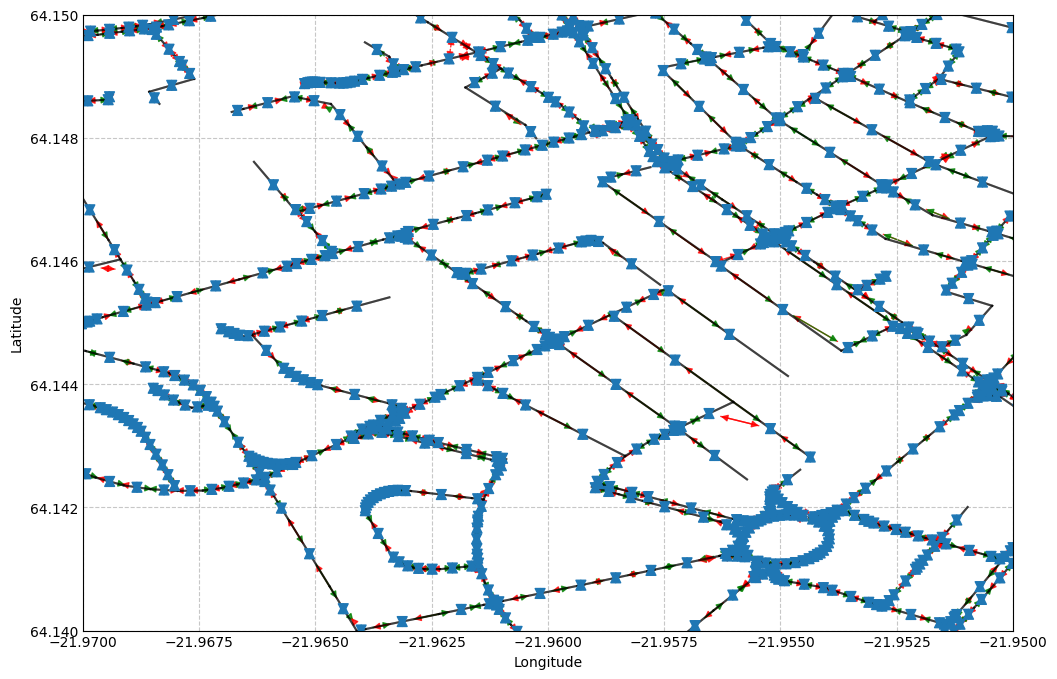

In [15]:
plot_edge_graph(edge_G, xlim=(x_min, x_max), ylim=(
    y_min, y_max), add_map=False)

/tmp/ipykernel_23798/1925050419.py:83: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(subgraph, pos_edge_G,


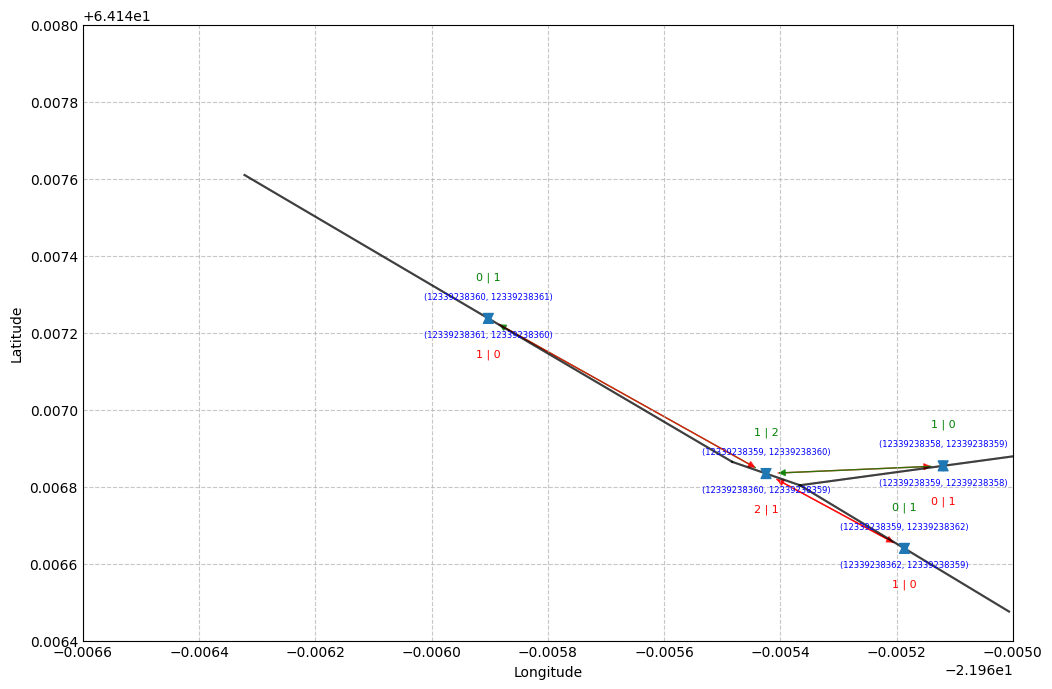

In [16]:
plot_edge_graph(edge_G, xlim=(-21.9665, -21.965), ylim=(64.1465,
                64.148), show_node_ids=True, show_nodes_labels=True, text_offset=0.00005)

In [17]:
find_nodes_in_bounds_edge_graph(edge_G, -21.9665, -21.965, 64.1465, 64.148)

[(12339238358, 12339238359),
 (12339238359, 12339238358),
 (12339238359, 12339238360),
 (12339238359, 12339238362),
 (12339238360, 12339238359),
 (12339238360, 12339238361),
 (12339238362, 12339238359),
 (12339238361, 12339238360)]

In [18]:
print(find_all_edges_for_node(edge_G, (12339220500, 12339220501)))
print()
print(find_all_edges_for_node(edge_G, (12339220501, 12339220500)))

Outgoing edges for node (12339220500, 12339220501):
Edge: (12339220500, 12339220501) -> (12339220501, 12339220502) with data: {'geometry': <POINT (-21.967 64.146)>}
Incoming edges for node (12339220500, 12339220501):
Edge: (12339220499, 12339220500) -> (12339220500, 12339220501) with data: {'geometry': <POINT (-21.968 64.145)>}
None

Outgoing edges for node (12339220501, 12339220500):
Edge: (12339220501, 12339220500) -> (12339220500, 12339220499) with data: {'geometry': <POINT (-21.968 64.145)>}
Incoming edges for node (12339220501, 12339220500):
Edge: (12339220502, 12339220501) -> (12339220501, 12339220500) with data: {'geometry': <POINT (-21.967 64.146)>}
None


In [19]:
print(find_all_edges_for_node(edge_G, (12339220500, 12339220501)))
print()
print(find_all_edges_for_node(edge_G, (12339220501, 12339220500)))

Outgoing edges for node (12339220500, 12339220501):
Edge: (12339220500, 12339220501) -> (12339220501, 12339220502) with data: {'geometry': <POINT (-21.967 64.146)>}
Incoming edges for node (12339220500, 12339220501):
Edge: (12339220499, 12339220500) -> (12339220500, 12339220501) with data: {'geometry': <POINT (-21.968 64.145)>}
None

Outgoing edges for node (12339220501, 12339220500):
Edge: (12339220501, 12339220500) -> (12339220500, 12339220499) with data: {'geometry': <POINT (-21.968 64.145)>}
Incoming edges for node (12339220501, 12339220500):
Edge: (12339220502, 12339220501) -> (12339220501, 12339220500) with data: {'geometry': <POINT (-21.967 64.146)>}
None


In [20]:
# Assuming edge_G is already defined and is a directed graph
simplified_G = nx.DiGraph()
visited_nodes = set()

# Step 1: Identify trivial and untrivial nodes
trivial_nodes = set(
    node for node in edge_G.nodes()
    if edge_G.in_degree(node) == 1 and edge_G.out_degree(node) == 1
)

untrivial_nodes = set(edge_G.nodes()) - trivial_nodes

# Copy untrivial nodes and edges to simplified_G
for node in untrivial_nodes:
    simplified_G.add_node(node, **edge_G.nodes[node])
    for successor in edge_G.successors(node):
        if successor in untrivial_nodes:
            simplified_G.add_edge(node, successor,
                                  **edge_G.edges[node, successor])

# Step 2: Cluster trivial nodes
while trivial_nodes:
    starting_node = trivial_nodes.pop()
    if starting_node in visited_nodes:
        continue

    cluster = [starting_node]
    visited_nodes.add(starting_node)
    internal_junctions = edge_G.nodes[starting_node].get(
        'internal_junctions', [])

    # Traverse backward to find the start of the cluster
    current_node = starting_node
    while True:
        preds = list(edge_G.predecessors(current_node))
        if len(preds) != 1:
            break
        pred = preds[0]
        if pred in trivial_nodes:
            cluster.insert(0, pred)
            visited_nodes.add(pred)
            trivial_nodes.remove(pred)
            current_node = pred
        else:
            left_neighbor = pred
            break
    else:
        left_neighbor = None  # No predecessor

    # Traverse forward to find the end of the cluster
    current_node = starting_node
    while True:
        succs = list(edge_G.successors(current_node))
        if len(succs) != 1:
            break
        succ = succs[0]
        if succ in trivial_nodes:
            cluster.append(succ)
            visited_nodes.add(succ)
            trivial_nodes.remove(succ)
            current_node = succ
        else:
            right_neighbor = succ
            break
    else:
        right_neighbor = None  # No successor

    # Step 3: Merge the cluster into a single node
    if len(cluster) == 1:
        # Single node cluster, copy it to simplified_G
        simplified_G.add_node(cluster[0], **edge_G.nodes[cluster[0]])
        if left_neighbor:
            simplified_G.add_edge(left_neighbor, cluster[0],
                                  **edge_G.edges[left_neighbor, cluster[0]])
        if right_neighbor:
            simplified_G.add_edge(cluster[0], right_neighbor,
                                  **edge_G.edges[cluster[0], right_neighbor])
    else:
        # Create a new node representing the cluster
        new_cluster_name = (cluster[0][0], cluster[-1][1])

        # Merge the geometries of the nodes in the cluster
        geometries = [edge_G.nodes[node]['geometry'] for node in cluster]
        geometry = linemerge(geometries)

        # Collect internal junctions
        for node in cluster:
            internal_junctions.extend(
                edge_G.nodes[node].get('internal_junctions', []))

        # Add the new node to simplified_G
        simplified_G.add_node(new_cluster_name,
                              internal_nodes=cluster,
                              internal_junctions=internal_junctions,
                              geometry=geometry)

        # Add edges to left and right neighbors
        if left_neighbor:
            simplified_G.add_edge(left_neighbor, new_cluster_name,
                                  **edge_G.edges[left_neighbor, cluster[0]])
        if right_neighbor:
            simplified_G.add_edge(new_cluster_name, right_neighbor,
                                  **edge_G.edges[cluster[-1], right_neighbor])

In [21]:
# Optional: Print the number of nodes and edges
print("Before simplification:")
print(f"Nodes: {len(edge_G.nodes())}, Edges: {len(edge_G.edges())}")
print("After simplification:")
print(f"Nodes: {len(simplified_G.nodes())}, Edges: {len(simplified_G.edges())}")

Before simplification:
Nodes: 109166, Edges: 117306
After simplification:
Nodes: 39222, Edges: 47354


In [22]:
edge_G = add_cluster_attribute_connected_components(edge_G)
simplified_G = add_cluster_attribute_connected_components(simplified_G)

In [23]:
print_graph_info(edge_G)

Directed has 109166 nodes and 117306 edges
+----------------------+
Nodes
+----------------------+
*** Node: (12339218092, 12339218091) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.938 64.067, -21.937 64.067)>, 'cluster': 0}
*** Node: (12339218092, 12339218093) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.938 64.067, -21.938 64.067)>, 'cluster': 0}
*** Node: (12339218098, 12339218091) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.938 64.068, -21.937 64.067)>, 'cluster': 0}
*** Node: (12339218098, 12339218099) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.938 64.068, -21.938 64.068)>, 'cluster': 0}
*** Node: (12339218091, 12339218092) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.937 64.067, -21.938 64.067)>, 'cluster': 0}
*** Node: (12339218091, 12339218098) ***
  Dat

In [24]:
print_graph_info(simplified_G)

Directed has 39222 nodes and 47354 edges
+----------------------+
Nodes
+----------------------+
*** Node: (12339234197, 12339226190) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.75 64.129, -21.75 64.129)>, 'cluster': 0}
*** Node: (12339238501, 12339234194) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.741 64.128, -21.741 64.128)>, 'cluster': 1}
*** Node: (12339234194, 12339238499) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.741 64.128, -21.741 64.128)>, 'cluster': 1}
*** Node: (12339269332, 12339269333) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.665 64.159, -21.665 64.159)>, 'cluster': 2}
*** Node: (12339252098, 12339239872) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.978 64.043, -21.978 64.043)>, 'cluster': 3}
*** Node: (12339239872, 12339239871) ***
  Data: {

/tmp/ipykernel_23798/1925050419.py:83: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(subgraph, pos_edge_G,


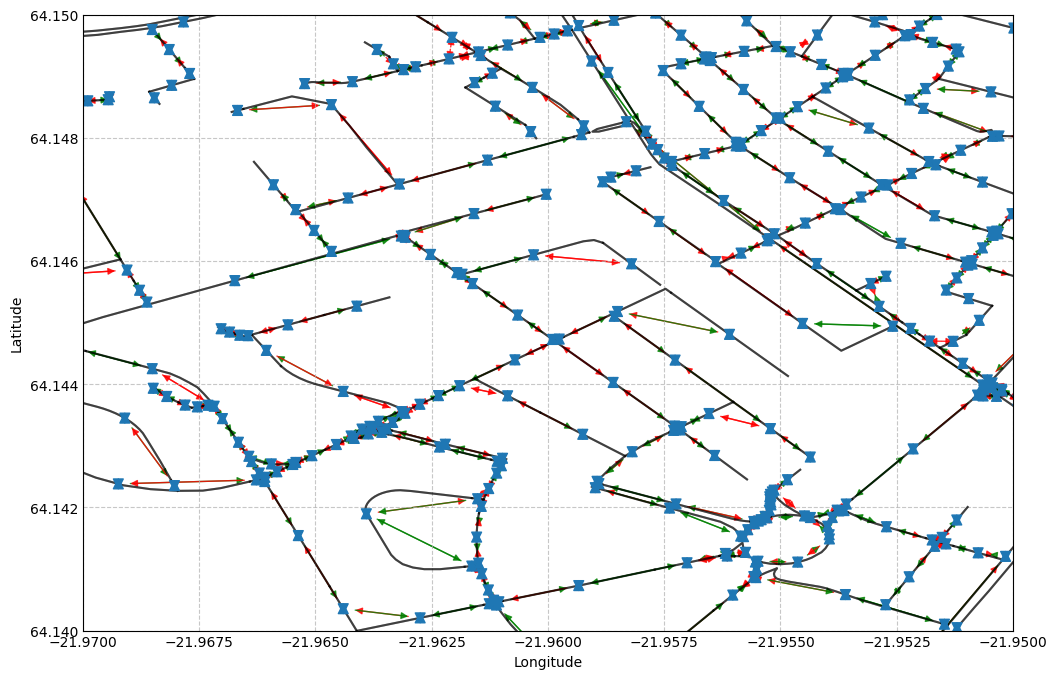

In [25]:
plot_edge_graph(simplified_G, xlim=(x_min, x_max), ylim=(y_min, y_max))

In [26]:
save_graph_to_geojson(
    simplified_G, "../data/simplified_nodes.geojson", "../data/simplified_edges.geojson")

Nodes (LineStrings) saved to ../data/simplified_nodes.geojson
Edges (Points) saved to ../data/simplified_edges.geojson


In [27]:
# Find the largest connected component
largest_cc = max(nx.weakly_connected_components(simplified_G), key=len)

# Create a subgraph with only the largest connected component
simplified_G = simplified_G.subgraph(largest_cc).copy()

In [28]:
nodes_in_1_out_0 = [node for node in edge_G.nodes() if edge_G.in_degree(
    node) == 1 and edge_G.out_degree(node) == 0]
print(nodes_in_1_out_0)

[(12339218122, 12339218123), (12339256777, 12339256776), (12339218443, 12339218444), (12339224045, 12339218578), (12339220959, 12339218589), (12339222771, 12339218604), (12339218606, 12339218605), (12339265083, 12339218605), (12339218670, 12339218671), (12339264680, 12339218671), (12339218673, 12339218672), (12339218760, 12339218761), (12339219113, 12339219112), (12339218900, 12339218901), (12339218957, 12339218956), (12339218985, 12339218986), (12339218996, 12339218997), (12339219000, 12339219001), (12339219045, 12339219044), (12339219072, 12339219073), (12339219101, 12339219102), (12339219146, 12339219147), (12339219152, 12339219153), (12339219168, 12339219169), (12339219175, 12339219176), (12339220011, 12339220012), (12339221095, 12339219288), (12339219258, 12339219259), (12339219260, 12339219259), (12339219262, 12339219263), (12339219277, 12339219278), (12339219287, 12339219288), (12339219285, 12339219286), (12339219289, 12339219286), (12339219290, 12339219291), (12339219317, 12339

/tmp/ipykernel_23798/1925050419.py:83: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(subgraph, pos_edge_G,


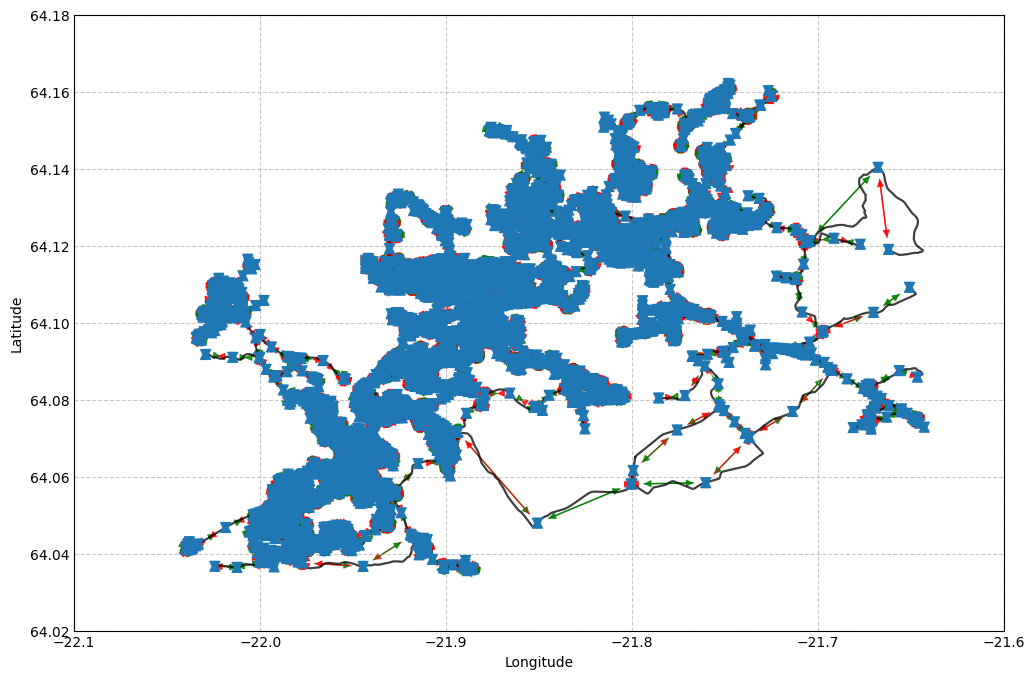

In [29]:
full_map_lim = ((-22.1, -21.6), (64.02, 64.18))

plot_edge_graph(
    simplified_G, xlim=full_map_lim[0], ylim=full_map_lim[1], add_map=False)

/tmp/ipykernel_23798/1925050419.py:83: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(subgraph, pos_edge_G,


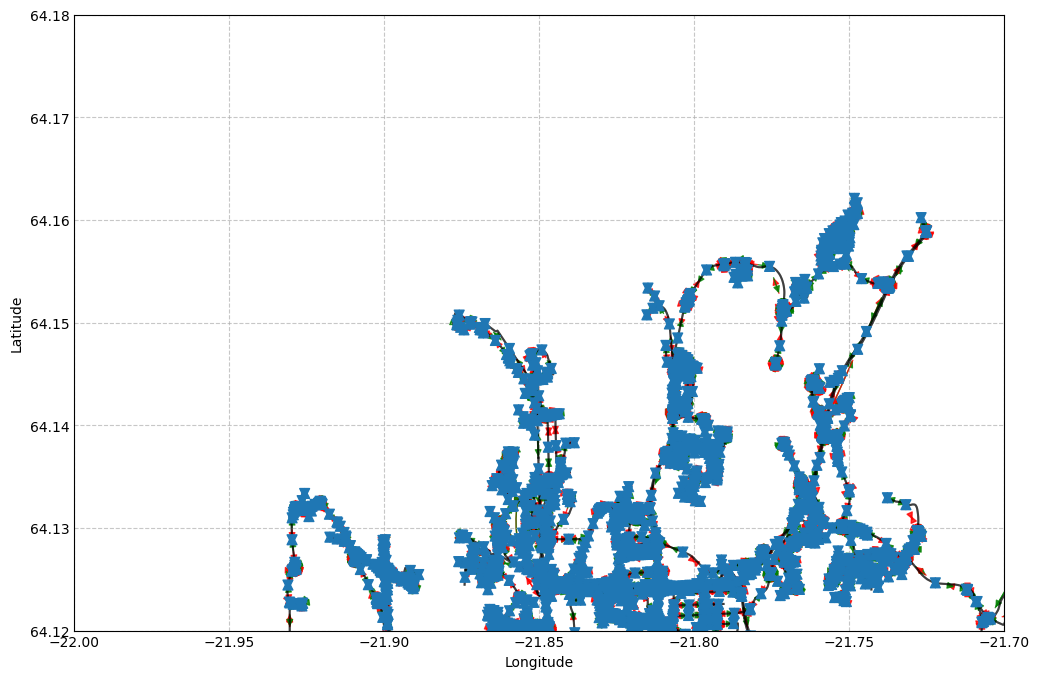

In [30]:
plot_edge_graph(simplified_G, xlim=(-22, -21.7),
                ylim=(64.12, 64.18), add_map=False)

# plot_edge_graph(simplified_G, xlim=(x_min, x_max), ylim=( y_min, y_max))

/tmp/ipykernel_23798/1925050419.py:83: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(subgraph, pos_edge_G,


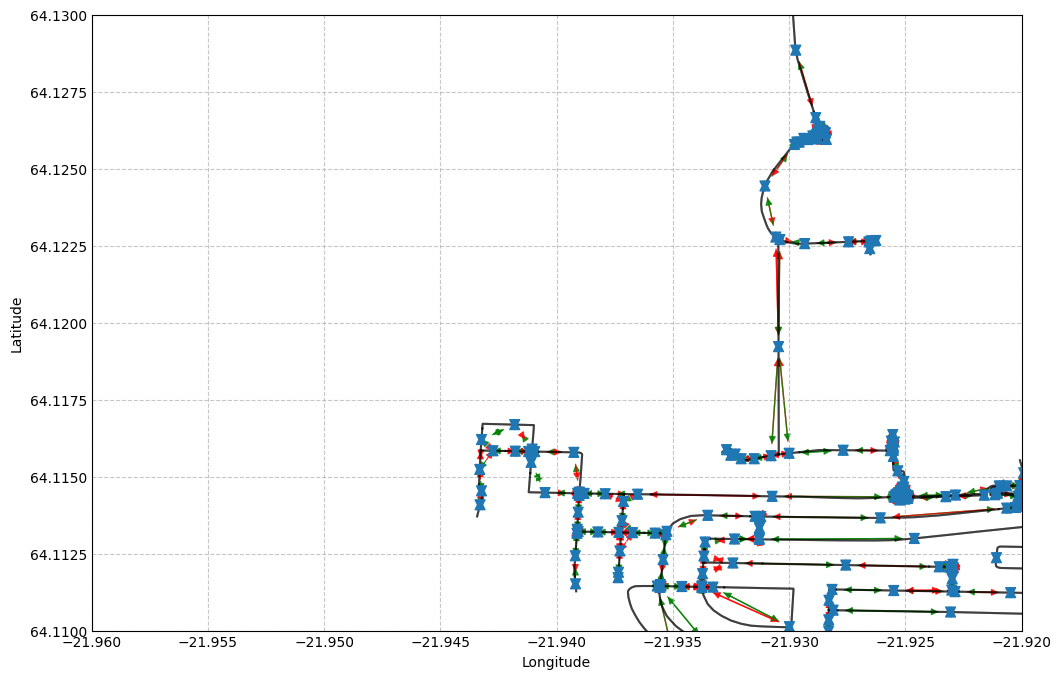

In [31]:
plot_edge_graph(simplified_G,  xlim=(-21.96, -21.92),
                ylim=(64.11, 64.13), add_map=False)

/tmp/ipykernel_23798/1925050419.py:83: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(subgraph, pos_edge_G,


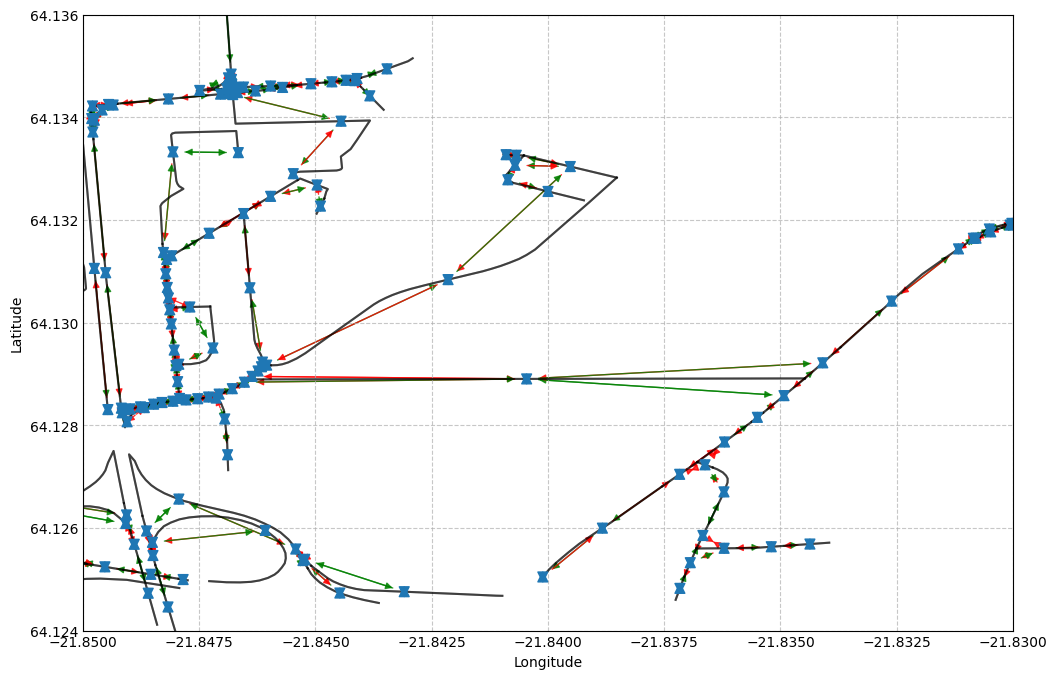

In [32]:
plot_edge_graph(simplified_G, xlim=(-21.85, -21.83),
                ylim=(64.125, 64.135), add_map=False)

In [33]:
s_G = simplified_G.copy()

In [34]:
def prune_graph(graph, length_threshold=1.0):
    """
    Prune a directed graph by removing nodes with road lengths below the threshold
    if they are connected to only one other node (hanging nodes).
    """
    to_remove = True

    while to_remove:
        to_remove = []
        for node, data in list(graph.nodes(data=True)):
            # Check if the node has geometry and is a hanging node
            if graph.degree(node) == 1:
                geometry = data.get('geometry', None)

                # Ensure geometry is defined and is a LINESTRING
                if geometry and isinstance(geometry, LineString):
                    length = compute_length(geometry)
                    if length < length_threshold:
                        to_remove.append(node)

        # Remove identified nodes
        graph.remove_nodes_from(to_remove)

    return graph

In [35]:
s_G = prune_graph(s_G, length_threshold=1)
print_graph_info(s_G)

Directed has 17024 nodes and 22704 edges
+----------------------+
Nodes
+----------------------+
*** Node: (12339252098, 12339239872) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.978 64.043, -21.978 64.043)>, 'cluster': 3}
*** Node: (12339239872, 12339239871) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.978 64.043, -21.978 64.043)>, 'cluster': 3}
*** Node: (12339239872, 12339252097) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.978 64.043, -21.978 64.043)>, 'cluster': 3}
*** Node: (12339241429, 12339241423) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.96 64.059, -21.961 64.059)>, 'cluster': 3}
*** Node: (12339241423, 12339241422) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.961 64.059, -21.961 64.059)>, 'cluster': 3}
*** Node: (12339241423, 12339241424) ***
  Data: 

In [36]:
s_G = prune_graph(s_G, length_threshold=1)
print_graph_info(s_G)

Directed has 17024 nodes and 22704 edges
+----------------------+
Nodes
+----------------------+
*** Node: (12339252098, 12339239872) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.978 64.043, -21.978 64.043)>, 'cluster': 3}
*** Node: (12339239872, 12339239871) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.978 64.043, -21.978 64.043)>, 'cluster': 3}
*** Node: (12339239872, 12339252097) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.978 64.043, -21.978 64.043)>, 'cluster': 3}
*** Node: (12339241429, 12339241423) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.96 64.059, -21.961 64.059)>, 'cluster': 3}
*** Node: (12339241423, 12339241422) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.961 64.059, -21.961 64.059)>, 'cluster': 3}
*** Node: (12339241423, 12339241424) ***
  Data: 

/tmp/ipykernel_23798/1925050419.py:83: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(subgraph, pos_edge_G,


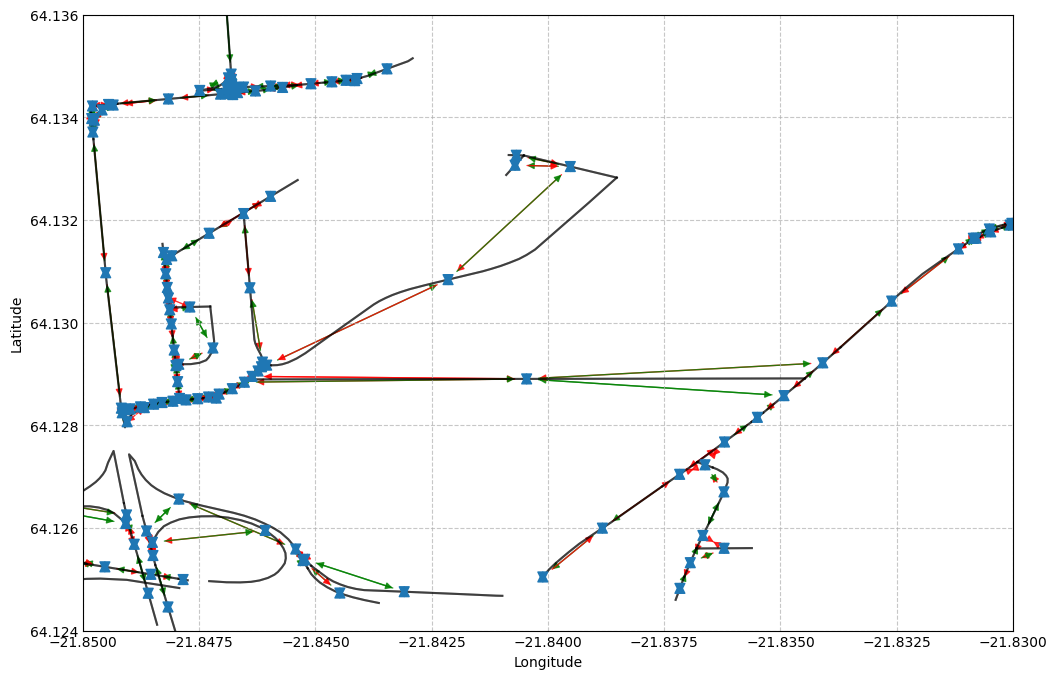

In [37]:
plot_edge_graph(s_G, xlim=(-21.85, -21.83),
                ylim=(64.125, 64.135), add_map=False)

/tmp/ipykernel_23798/1925050419.py:83: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(subgraph, pos_edge_G,


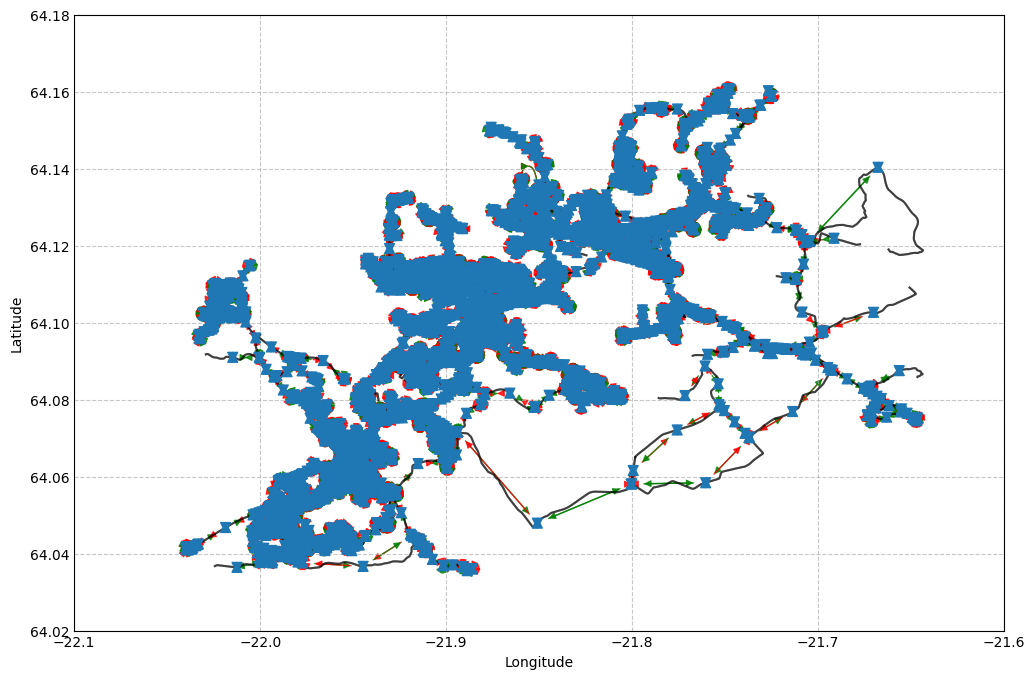

In [38]:
plot_edge_graph(s_G)

In [39]:
save_graph(edge_G, '../data/full_roads_edge_graph.json')
save_graph(simplified_G, '../data/simplified_roads_edge_graph.json')

In [40]:
center_coords = ((-21.95, -21.8), (64.1, 64.16))

center_edge_graph = create_edge_subgraph(
    s_G, xlim=center_coords[0], ylim=center_coords[1])

/tmp/ipykernel_23798/1925050419.py:83: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(subgraph, pos_edge_G,


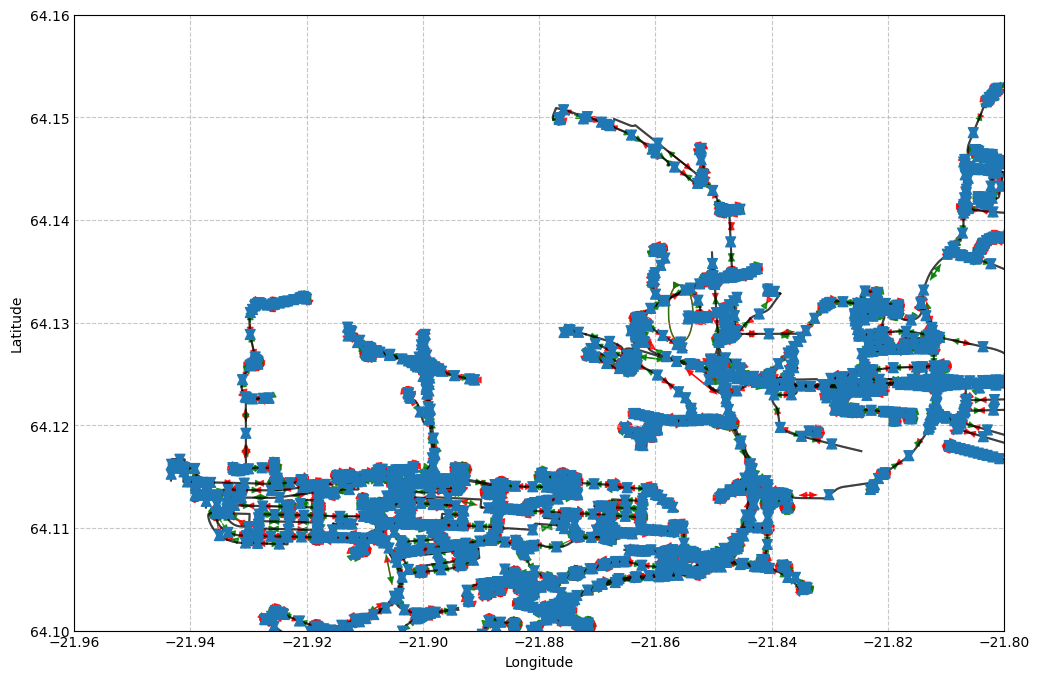

In [41]:
plot_edge_graph(center_edge_graph,
                xlim=center_coords[0], ylim=center_coords[1], add_map=False)

In [42]:
print_graph_info(center_edge_graph)

Directed has 5472 nodes and 7260 edges
+----------------------+
Nodes
+----------------------+
*** Node: (12339266083, 12339266075) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.802 64.124, -21.803 64.124)>, 'cluster': 3}
*** Node: (12339264013, 12339224582) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.813 64.124, -21.813 64.124)>, 'cluster': 3}
*** Node: (12339264425, 12339264419) ***
  Data: {'internal_nodes': [(12339264425, 12339264424), (12339264424, 12339264423), (12339264423, 12339264422), (12339264422, 12339264421), (12339264421, 12339264420), (12339264420, 12339264419)], 'internal_junctions': [], 'geometry': <LINESTRING (-21.863 64.129, -21.863 64.129, -21.863 64.129, -21.863 64.129,...>, 'cluster': 3}
*** Node: (12339224574, 12339224561) ***
  Data: {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.813 64.124, -21.814 64.124)>, 'cluster': 3}
*** Node: (123392453

In [43]:
save_graph_to_geojson(
    center_edge_graph, '../data/center_edge_graph_nodes.geojson', '../data/center_edge_graph_edges.geojson')

Nodes (LineStrings) saved to ../data/center_edge_graph_nodes.geojson
Edges (Points) saved to ../data/center_edge_graph_edges.geojson


In [44]:
center_edge_graph.nodes(data=True)

NodeDataView({(12339266083, 12339266075): {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.802 64.124, -21.803 64.124)>, 'cluster': 3}, (12339264013, 12339224582): {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.813 64.124, -21.813 64.124)>, 'cluster': 3}, (12339264425, 12339264419): {'internal_nodes': [(12339264425, 12339264424), (12339264424, 12339264423), (12339264423, 12339264422), (12339264422, 12339264421), (12339264421, 12339264420), (12339264420, 12339264419)], 'internal_junctions': [], 'geometry': <LINESTRING (-21.863 64.129, -21.863 64.129, -21.863 64.129, -21.863 64.129,...>, 'cluster': 3}, (12339224574, 12339224561): {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.813 64.124, -21.814 64.124)>, 'cluster': 3}, (12339245332, 12339245326): {'internal_nodes': [], 'internal_junctions': [], 'geometry': <LINESTRING (-21.89 64.104, -21.89 64.105)>, 'cluster': 3}, (12339249962, 12339230310): {'in

In [45]:
given_coordinate = (-21.84, 64.1285)
print(given_coordinate)
# Use the function to get sorted nodes
sorted_nodes_0 = get_nodes_sorted_by_distance(
    center_edge_graph, given_coordinate)

# Print top 5 nodes sorted by distance
for node, dist in sorted_nodes_0[:5]:
    print(f"Node: {node}, Distance: {dist:.3f} km")

given_coordinate = (-21.8325, 64.130)
print(given_coordinate)
# Use the function to get sorted nodes
sorted_nodes_1 = get_nodes_sorted_by_distance(
    center_edge_graph, given_coordinate)

# Print top 5 nodes sorted by distance
for node, dist in sorted_nodes_1[:5]:
    print(f"Node: {node}, Distance: {dist:.3f} km")

(-21.84, 64.1285)
Node: (12339227771, 12339229647), Distance: 0.050 km
Node: (12339229647, 12339227771), Distance: 0.050 km
Node: (12339229626, 12339229645), Distance: 0.206 km
Node: (12339229645, 12339229626), Distance: 0.206 km
Node: (12339229626, 12339229635), Distance: 0.212 km
(-21.8325, 64.13)
Node: (12339229648, 12339229652), Distance: 0.046 km
Node: (12339229652, 12339229648), Distance: 0.046 km
Node: (12339229647, 12339229648), Distance: 0.116 km
Node: (12339229648, 12339229647), Distance: 0.116 km
Node: (12339229652, 12339229653), Distance: 0.172 km


In [46]:
# center_edge_graph.nodes[closest]

In [47]:
import networkx as nx


def shortest_path_node_distance_with_path(G, node_a, node_b):
    """
    Calculate the shortest path and its length between two nodes in the graph.

    Parameters:
    G : nx.Graph
        The input graph.
    node_a : any
        The first node.
    node_b : any
        The second node.

    Returns:
    tuple
        A tuple containing the number of nodes in the shortest path
        (including start and end nodes) and the path itself.
    """
    try:
        path = nx.shortest_path(G, source=node_a, target=node_b)
        return len(path) - 1, path  # Number of edges and the path
    except nx.NetworkXNoPath:
        # Return infinity and empty path if no path exists
        return float('inf'), []


def find_all_distances_with_paths(G, sorted_nodes_0, sorted_nodes_1):
    """
    Find all combinations of shortest path distances and paths between
    the closest nodes to two given coordinates.

    Parameters:
    G : nx.Graph
        The input graph.
    sorted_nodes_0 : list
        Closest nodes to the first coordinate, sorted by distance.
    sorted_nodes_1 : list
        Closest nodes to the second coordinate, sorted by distance.

    Returns:
    dict
        A dictionary with distances and paths between all combinations of nodes.
    """
    closest_pairs = sorted_nodes_0[:2], sorted_nodes_1[:2]
    results = {}

    for i, node_0 in enumerate(closest_pairs[0]):
        for j, node_1 in enumerate(closest_pairs[1]):
            dist, path = shortest_path_node_distance_with_path(
                G, node_0[0], node_1[0])
            results[(node_0[0], node_1[0])] = {"distance": dist, "path": path}

    return results


# Example usage
given_coordinate_0 = (-21.84, 64.1285)
sorted_nodes_0 = get_nodes_sorted_by_distance(
    center_edge_graph, given_coordinate_0)

given_coordinate_1 = (-21.8325, 64.13)
sorted_nodes_1 = get_nodes_sorted_by_distance(
    center_edge_graph, given_coordinate_1)

# Find all distances and paths between closest pairs of nodes
all_distances_with_paths = find_all_distances_with_paths(
    center_edge_graph, sorted_nodes_0, sorted_nodes_1)

# Print the results
print("Distances and paths between closest nodes:")
for (node_0, node_1), result in all_distances_with_paths.items():
    print(f"From {node_0} to {node_1}: {result['distance']} nodes")
    print(f"Path: {result['path']}")

Distances and paths between closest nodes:
From (12339227771, 12339229647) to (12339229648, 12339229652): 2 nodes
Path: [(12339227771, 12339229647), (12339229647, 12339229648), (12339229648, 12339229652)]
From (12339227771, 12339229647) to (12339229652, 12339229648): 11 nodes
Path: [(12339227771, 12339229647), (12339229647, 12339229648), (12339229648, 12339229652), (12339229652, 12339229653), (12339229653, 12339263496), (12339263496, 12339263492), (12339263492, 12339263478), (12339263478, 12339263477), (12339263477, 12339263474), (12339263474, 12339229653), (12339229653, 12339229652), (12339229652, 12339229648)]
From (12339229647, 12339227771) to (12339229648, 12339229652): 27 nodes
Path: [(12339229647, 12339227771), (12339227771, 12339227770), (12339227770, 12339227769), (12339227769, 12339227761), (12339227761, 12339227775), (12339227775, 12339227777), (12339227777, 12339227778), (12339227778, 12339227785), (12339227785, 12339227788), (12339227788, 12339227789), (12339227789, 1233922